# Chapter 20: Text mining

> (c) 2019 Galit Shmueli, Peter C. Bruce, Peter Gedeck 
>
> Code included in
>
> _Data Mining for Business Analytics: Concepts, Techniques, and Applications in Python_ (First Edition) 
> Galit Shmueli, Peter C. Bruce, Peter Gedeck, and Nitin R. Patel. 2019.

## Import required packages

In [1]:
%matplotlib inline

from pathlib import Path

from zipfile import ZipFile
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import Normalizer
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
import nltk
from nltk import word_tokenize          
from nltk.stem.snowball import EnglishStemmer 
import matplotlib.pylab as plt
from dmba import printTermDocumentMatrix, classificationSummary, liftChart

nltk.download('punkt')


[nltk_data] Downloading package punkt to /Users/peter/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Table 20.1 Term-document representation of words in sentences S1-S3
 

In [2]:
text = ['this is the first sentence.',
        'this is a second sentence.',
        'the third sentence is here.']

# Learn features based on text
count_vect = CountVectorizer()
counts = count_vect.fit_transform(text)

printTermDocumentMatrix(count_vect, counts)

          S1  S2  S3
first      1   0   0
here       0   0   1
is         1   1   1
second     0   1   0
sentence   1   1   1
the        1   0   1
third      0   0   1
this       1   1   0


## Table 20.2 Term-document representation of words in sentences S1-S4 (Example 2)

In [3]:
text = ['this is the first     sentence!!',
        'this is a second Sentence :)',
        'the third sentence, is here ',
        'forth of all sentences']

# Learn features based on text. Include special characters that are part of a word in the analysis
count_vect = CountVectorizer()
counts = count_vect.fit_transform(text)

printTermDocumentMatrix(count_vect, counts)

           S1  S2  S3  S4
all         0   0   0   1
first       1   0   0   0
forth       0   0   0   1
here        0   0   1   0
is          1   1   1   0
of          0   0   0   1
second      0   1   0   0
sentence    1   1   1   0
sentences   0   0   0   1
the         1   0   1   0
third       0   0   1   0
this        1   1   0   0


## Table 20.3 Tokenization of S1-S4

In [4]:
text = ['this is the first     sentence!!',
        'this is a second Sentence :)',
        'the third sentence, is here ',
        'forth of all sentences']

# Learn features based on text. Include special characters that are part of a word in the analysis
count_vect = CountVectorizer(token_pattern='[a-zA-Z!:)]+')
counts = count_vect.fit_transform(text)

printTermDocumentMatrix(count_vect, counts)

            S1  S2  S3  S4
:)           0   1   0   0
a            0   1   0   0
all          0   0   0   1
first        1   0   0   0
forth        0   0   0   1
here         0   0   1   0
is           1   1   1   0
of           0   0   0   1
second       0   1   0   0
sentence     0   1   1   0
sentence!!   1   0   0   0
sentences    0   0   0   1
the          1   0   1   0
third        0   0   1   0
this         1   1   0   0


## Table 20.4 Stopwords in scitkit-learn

In [5]:
stopWords = list(sorted(ENGLISH_STOP_WORDS))
ncolumns = 6; nrows= 30

print('First {} of {} stopwords'.format(ncolumns * nrows, len(stopWords)))
for i in range(0, len(stopWords[:(ncolumns * nrows)]), ncolumns):
    print(''.join(word.ljust(13) for word in stopWords[i:(i+ncolumns)]))

First 180 of 318 stopwords
a            about        above        across       after        afterwards   
again        against      all          almost       alone        along        
already      also         although     always       am           among        
amongst      amoungst     amount       an           and          another      
any          anyhow       anyone       anything     anyway       anywhere     
are          around       as           at           back         be           
became       because      become       becomes      becoming     been         
before       beforehand   behind       being        below        beside       
besides      between      beyond       bill         both         bottom       
but          by           call         can          cannot       cant         
co           con          could        couldnt      cry          de           
describe     detail       do           done         down         due          
during       each        

## Table 20.5 Text reduction of S1-S4 using stemming

In [6]:
text = ['this is the first     sentence!! ',
        'this is a second Sentence :)',
        'the third sentence, is here ',
        'forth of all sentences']

# Create a custom tokenizer that will use NLTK for tokenizing and lemmatizing 
# (removes interpunctuation and stop words)
class LemmaTokenizer(object):
    def __init__(self):
        self.stemmer = EnglishStemmer()
        self.stopWords = set(ENGLISH_STOP_WORDS)

    def __call__(self, doc):
        return [self.stemmer.stem(t) for t in word_tokenize(doc) 
                if t.isalpha() and t not in self.stopWords]

# Learn features based on text
count_vect = CountVectorizer(tokenizer=LemmaTokenizer())
counts = count_vect.fit_transform(text)

printTermDocumentMatrix(count_vect, counts)

         S1  S2  S3  S4
forth     0   0   0   1
second    0   1   0   0
sentenc   1   1   1   1


## Table 20.6 tf-idf matrix for S1-S4 example (after tokenization)

In [7]:
text = ['this is the first     sentence!!',
        'this is a second Sentence :)',
        'the third sentence, is here ',
        'forth of all sentences']

# Apply CountVectorizer and TfidfTransformer sequentially
count_vect = CountVectorizer()
tfidfTransformer = TfidfTransformer(smooth_idf=False, norm=None)
counts = count_vect.fit_transform(text)
tfidf = tfidfTransformer.fit_transform(counts)

printTermDocumentMatrix(count_vect, tfidf)

                 S1        S2        S3        S4
all        0.000000  0.000000  0.000000  2.386294
first      2.386294  0.000000  0.000000  0.000000
forth      0.000000  0.000000  0.000000  2.386294
here       0.000000  0.000000  2.386294  0.000000
is         1.287682  1.287682  1.287682  0.000000
of         0.000000  0.000000  0.000000  2.386294
second     0.000000  2.386294  0.000000  0.000000
sentence   1.287682  1.287682  1.287682  0.000000
sentences  0.000000  0.000000  0.000000  2.386294
the        1.693147  0.000000  1.693147  0.000000
third      0.000000  0.000000  2.386294  0.000000
this       1.693147  1.693147  0.000000  0.000000


## Table 20.7 Importing and labeling the records, preprocessing text, and producing concept matrix

In [8]:
# Step 1: import and label records
corpus = []
label = []
with ZipFile('AutoAndElectronics.zip') as rawData:
    for info in rawData.infolist():
        if info.is_dir(): 
            continue
        label.append(1 if 'rec.autos' in info.filename else 0)
        corpus.append(rawData.read(info))

# Step 2: preprocessing (tokenization, stemming, and stopwords)
class LemmaTokenizer(object):
    def __init__(self):
        self.stemmer = EnglishStemmer()
        self.stopWords = set(ENGLISH_STOP_WORDS)
    def __call__(self, doc):
        return [self.stemmer.stem(t) for t in word_tokenize(doc) 
                if t.isalpha() and t not in self.stopWords]

preprocessor = CountVectorizer(tokenizer=LemmaTokenizer(), encoding='latin1')
preprocessedText = preprocessor.fit_transform(corpus)

In [9]:

# Step 3: TF-IDF and latent semantic analysis
tfidfTransformer = TfidfTransformer()
tfidf = tfidfTransformer.fit_transform(preprocessedText)

# Extract 20 concepts using LSA ()
svd = TruncatedSVD(20)
normalizer = Normalizer(copy=False)
lsa = make_pipeline(svd, normalizer)

lsa_tfidf = lsa.fit_transform(tfidf)

## Table 20.8 Fitting a predictive model to the autos and electronics discussion data

In [10]:
# split dataset into 60% training and 40% test set
Xtrain, Xtest, ytrain, ytest = train_test_split(lsa_tfidf, label, test_size=0.4, random_state=42)

# run logistic regression model on training
logit_reg = LogisticRegression(solver='lbfgs')
logit_reg.fit(Xtrain, ytrain)

# print confusion matrix and accuracty
classificationSummary(ytest, logit_reg.predict(Xtest))

Confusion Matrix (Accuracy 0.9587)

       Prediction
Actual   0   1
     0 388   9
     1  24 379


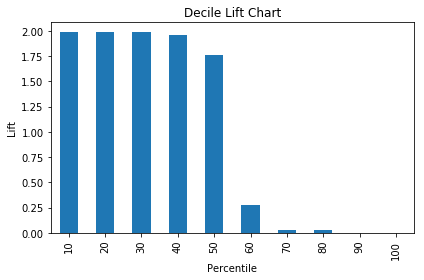

In [11]:
df = pd.DataFrame(data={'prob': [p[1] for p in logit_reg.predict_proba(Xtest)], 'actual': ytest})
df = df.sort_values(by=['prob'], ascending=False).reset_index(drop=True)

ax = liftChart(df.actual, labelBars=False)

plt.tight_layout()
plt.show()